### Вступительный экзамен DL Advanced Весна'23. Программирование

Данные взяты [отсюда](https://disk.yandex.ru/d/adjYzzNayB1pag).


При решении задания в качестве источника использовался [следующий туториал](https://deepayan137.github.io/blog/markdown/2020/08/29/building-ocr.html). Подход, реализованный в данной работе, основан на раздельном распознавании сокращенного названия провинции (первого иероглифа в номере) и оставшейся части номера, состоящей из заглавных латинских букв и цифр.


В данной работе подсчитыватся только доля правильных ответов по словам и по символам. CER не считалось, так как количество предсказываемых символов фиксированно и равно 7.

In [1]:
import numpy as np
import zipfile
import cv2
import os
import io
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.nn.utils.clip_grad import clip_grad_norm_
from torchvision import transforms as T
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import random
from datetime import timedelta
import time
from sklearn.metrics import accuracy_score
import yaml

In [2]:
with open("cfg.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)


DIR = cfg["data_path"]
if DIR.endswith(".zip"):
    DIR = DIR[:-4]

In [ ]:
# Разархивирование данных

with zipfile.ZipFile(f"{DIR}.zip", 'r') as zf:
    zf.extractall("")

# Выделениие валидационной выборки

os.mkdir(f"{DIR}/val/")
train_filenames = os.listdir(f"{DIR}/train")

train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.15, shuffle=True, random_state=42)

for filename in val_filenames:
    os.rename(f"{DIR}/train/{filename}", f"{DIR}/val/{filename}")
    
# Сжатие полученных трех выборок 

with zipfile.ZipFile(f"{DIR}.zip", "w") as zf:
    for dirname, subdirs, files in os.walk(f"{DIR}"):
        zf.write(dirname)
        for filename in tqdm(files):
            zf.write(os.path.join(dirname, filename))

# Удаление разархивированного файла

for split in "train", "val", "test":
    for filename in os.listdir(f"{DIR}/{split}"):
        os.remove(f"{DIR}/{split}/{filename}")
    os.rmdir(f"{DIR}/{split}")
os.rmdir(DIR)

In [3]:
tfms = T.Compose([
    T.ToTensor(),
    T.ConvertImageDtype(torch.uint8),
    T.CenterCrop((cfg["preprocess"]["img_height"], cfg["preprocess"]["img_width"])),
])

In [4]:
# Функция для выделение метки из названия файла и перевод в правильную кодировку

def label_filter(name):
    return name[name.find("-", 9) + 1:-4].encode('cp437').decode('utf-8')

In [5]:
provinces = cfg["provinces"]  # список всех сокращенных названий провинций Китая

vocab = [chr(idx) for idx in list(range(ord("A"), ord("Z") + 1)) + list(range(ord("0"), ord("9") + 1))]

In [6]:
province_map = {province: idx for idx, province in enumerate(provinces)}
symbol_map = {symbol: idx for idx, symbol in enumerate(vocab)}

province_map_rev = {idx: province for idx, province in enumerate(provinces)}
symbol_map_rev = {idx: symbol for idx, symbol in enumerate(vocab)}

In [7]:
# Класс для чтения данных из архивированного файла

def convert_name_to_labels(name):
    labels = [province_map[name[0]]] + [symbol_map[symbol] for symbol in name[1:]]
    return labels

def convert_labels_to_name(labels):
    name = "".join([province_map_rev[labels[0]]] + [symbol_map_rev[i] for i in labels[1:]])
    return name

def collate_fn(batch):
    imgs = torch.cat([item["img"].unsqueeze(0) for item in batch])
    labels = torch.cat([torch.LongTensor(convert_name_to_labels(item["label"])).unsqueeze(0) for item in batch], dim=0)
    return {"img": imgs, "label": labels}

class ZipDataset(Dataset):
    def __init__(self, path, label_filter=None, prefix="", transform=None):
        f = open(path, 'rb')
        self.zip_content = f.read()
        f.close()
        self.zip_file = zipfile.ZipFile(io.BytesIO(self.zip_content), 'r')
        self.label_filter = label_filter
        self.prefix = prefix
        self.name_list = list(filter(lambda filename: filename.endswith(".jpg") and filename.startswith(self.prefix),
                              self.zip_file.namelist()))
        self.transform = transform

    def __getitem__(self, key):
        name = self.name_list[key]
        buf = self.zip_file.read(name=name)
        img = cv2.imdecode(np.frombuffer(buf, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            img = self.transform(img)
        if self.label_filter:
            name = label_filter(name)
        img = img / 255
        return {"img": img, "label": name}

    def __len__(self):
        return len(self.name_list)


In [8]:
batch_size = cfg["training"]["batch_size"]

train_dataset = ZipDataset(cfg["data_path"], prefix=f"{DIR}/train", label_filter=label_filter, transform=tfms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = ZipDataset(cfg["data_path"], prefix=f"{DIR}/val", label_filter=label_filter, transform=tfms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

test_dataset = ZipDataset(cfg["data_path"], prefix=f"{DIR}/test", label_filter=label_filter, transform=tfms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

В основе реализованной в данной работе модели лежит модель из туториала.
Изменения:
    - Только один слой двунаправленной LSTM
    - Добавлены полносвязные слои для сжатия по ширине и высоте
    - Выход рекуррентного слоя разбивается на два. Первый выход преобразуется в распределение над словарем названий провинций, второй - в распределение на словарем латинских заглавных букв и цифр


In [9]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding_1 = nn.Linear(nHidden * 2, nOut[0])
        self.embedding_2 = nn.Linear(nHidden * 2, nOut[1])
        
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        recurrent = [recurrent[0], recurrent[1:]]
        t, b, h = recurrent[1].size()
        t_rec = recurrent[1].view(t * b, h)
        output = [self.embedding_1(recurrent[0]).view(1, b, -1), self.embedding_2(t_rec).view(t, b, -1)]
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d((2, 2), 2))
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d((2, 2), 2))
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(6, True)
        
        self.cnn = cnn

        self.rnn = BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nClasses'])
        self.linear_h = nn.Linear(7, 1)
        self.linear_w = nn.Linear(101, 7)

    def forward(self, input):
        conv = self.cnn(input)
        conv = self.linear_w(conv)
        conv = conv.permute(0, 1, 3, 2)
        conv = self.linear_h(conv)
        conv = conv.permute(0, 1, 3, 2)
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)
        output = self.rnn(conv)
        output[0] = output[0].squeeze()
        output[1] = output[1].transpose(1,0)
        return output

In [10]:
val_labels = torch.cat([batch["label"] for batch in val_dataloader], dim=0)
test_labels = torch.cat([batch["label"] for batch in test_dataloader], dim=0)

In [11]:
weights = np.ones(len(provinces))
labels, counts = np.unique(val_labels[:, 0], return_counts=True)

weights[labels] /= counts
weights /= weights.sum()
weights = torch.Tensor(weights)

In [12]:
device = torch.device(cfg["training"]["device"])
model = CRNN(cfg["model"]).to(device)
num_criterion = nn.CTCLoss(reduction="mean", zero_infinity=True)
province_criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=cfg["training"]["lr"])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["training"]["epochs"])

In [13]:
seed = cfg["training"]["seed"]

random.seed = (seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model.cuda()
pred_sizes = (torch.ones(batch_size) * 6).long().to(device)

train_losses = []
val_losses = []

for epoch in range(cfg["training"]["epochs"]):
    print("Training {} epoch".format(epoch + 1))
    start = time.time()
    mean_loss = 0
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader)):
        # if (step + 1) % 200 == 0:
        #     duration = timedelta(seconds=int(time.time() - start))
        #     print('Batch {:>5,}  of  {:>5,}. Loss {:.3}  Time: {:}.'.format(step + 1, len(train_dataloader), mean_loss / step, duration))
        
        torch.cuda.empty_cache()
        b_input = batch["img"].to(device)
        b_labels = batch["label"].to(device)
        model.zero_grad()
        
        province_logits, num_logits = model(b_input)
        province_logits = F.softmax(province_logits, 1)
        num_logits = F.log_softmax(num_logits, 2).transpose(0, 1)

        
        loss = province_criterion(province_logits, b_labels[:, 0])
        loss += num_criterion(num_logits, b_labels[:, 1:], pred_sizes[:len(b_labels)], pred_sizes[:len(b_labels)])
        
        optimizer.zero_grad()
        loss.backward()
        
        max_grad_norm = 0.05
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        mean_loss += loss.item()
        
    scheduler.step()
    mean_loss = mean_loss / len(train_dataloader)
    
    train_losses.append(mean_loss)
    print("Mean loss: " , mean_loss)
    print("Training epoch took:" , timedelta(seconds=int(time.time() - start)))
    torch.save(model, cfg["model_path"])
    print()
    print("Validation:")
    model.eval()

    start = time.time()
    predictions = torch.Tensor().to(dtype=torch.int8)
    val_loss = 0

    for batch in tqdm(val_dataloader):

        b_input = batch["img"].to(device)
        b_labels = batch["label"].to(device)

        with torch.no_grad():
            province_logits, num_logits = model(b_input)
            province_logits = F.softmax(province_logits, 1)
            num_logits = F.log_softmax(num_logits, 2).transpose(0, 1)

            loss = province_criterion(province_logits, b_labels[:, 0])
            loss += num_criterion(num_logits, b_labels[:, 1:], pred_sizes[:len(b_labels)], pred_sizes[:len(b_labels)])

        predictions = torch.cat((predictions, torch.cat((
            province_logits.argmax(dim=1).view(-1, 1).cpu().detach(), 
            num_logits.transpose(0, 1).argmax(dim=-1).cpu().detach()
            ), dim=1)), dim=0)
        torch.cuda.empty_cache()

    print("Accuracy by word: {:4.2f}".format(np.equal(val_labels, predictions).all(axis=1).float().mean()))
    print("Accuracy by char: {:4.2f}".format(np.equal(val_labels, predictions).float().mean()))
    val_losses.append(val_loss / len(val_dataloader))
    print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
    print()

Training 1 epoch


  0%|          | 0/1771 [00:00<?, ?it/s]

Mean loss:  3.495508072539146
Training epoch took: 0:54:16

Validation:


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy by word: 0.96
Accuracy by char: 0.99
Validation took: 0:03:08



In [13]:
model = torch.load(cfg["model_path"])

In [14]:
print("Testing:")
model.eval()

test_predictions = torch.Tensor().to(dtype=torch.int8)

for batch in tqdm(test_dataloader):

    b_input = batch["img"].to(device)
    b_labels = batch["label"].to(device)

    with torch.no_grad():
        province_logits, num_logits = model(b_input)
        province_logits = F.softmax(province_logits, 1)
        num_logits = F.log_softmax(num_logits, 2).transpose(0, 1)

    test_predictions = torch.cat((test_predictions, torch.cat((
        province_logits.argmax(dim=1).view(-1, 1).cpu().detach(),
        num_logits.transpose(0, 1).argmax(dim=-1).cpu().detach()
        ), dim=1)), dim=0)
    torch.cuda.empty_cache()

print("Accuracy by word: {:4.2f}".format(np.equal(test_labels, test_predictions).all(axis=1).float().mean()))
print("Accuracy by char: {:4.2f}".format(np.equal(test_labels, test_predictions).float().mean()))

Testing:


  0%|          | 0/105 [00:00<?, ?it/s]

Accuracy by word: 0.91
Accuracy by char: 0.98


За счет переданных в функцию потерь весов классов, модель научилась предсказывать названия провинций. Было проверено, что без данного шага модель бы всегда предсказывала одну и ту же провинцию 皖, т.к. среди тренировочных данных в основном были номера из провинции 皖. Для тестовых примеров с номера автомобилей из других провинций, модель правильно предсказала провинцию в 89%.

В дальнейшем можно улучшить предсказание провинции с помощью аугментации и насыщения корпуса изображениями с провинциями, которые встречаются редко.

In [15]:
mask = test_labels[:, 0] != test_predictions[:, 0]
pairs, counts = np.unique([province_map_rev[a] + province_map_rev[b] for a, b in zip(test_labels[mask, 0].numpy(), test_predictions[mask, 0].numpy())], return_counts=True)
print("Ошибки предсказания провинции: (количество, истинное значение, предсказанное)")
print(*sorted([(counts[i], pairs[i][0], pairs[i][1], ) for i in range(len(pairs))], reverse=True), sep="\n")

Ошибки предсказания провинции: (количество, истинное значение, предсказанное)
(19, '皖', '浙')
(9, '皖', '鲁')
(5, '皖', '渝')
(5, '皖', '沪')
(4, '皖', '粤')
(4, '皖', '湘')
(3, '赣', '浙')
(3, '蒙', '豫')
(3, '皖', '鄂')
(3, '皖', '苏')
(3, '晋', '辽')
(3, '新', '浙')
(2, '鲁', '津')
(2, '蒙', '苏')
(2, '苏', '赣')
(2, '苏', '浙')
(2, '皖', '闽')
(2, '皖', '豫')
(2, '皖', '冀')
(2, '湘', '闽')
(1, '黑', '皖')
(1, '黑', '津')
(1, '黑', '冀')
(1, '青', '川')
(1, '陕', '闽')
(1, '陕', '赣')
(1, '陕', '豫')
(1, '陕', '浙')
(1, '陕', '冀')
(1, '闽', '皖')
(1, '鄂', '豫')
(1, '鄂', '皖')
(1, '辽', '皖')
(1, '赣', '津')
(1, '贵', '皖')
(1, '贵', '冀')
(1, '豫', '冀')
(1, '苏', '皖')
(1, '皖', '津')
(1, '皖', '川')
(1, '甘', '川')
(1, '琼', '粤')
(1, '湘', '赣')
(1, '湘', '苏')
(1, '湘', '浙')
(1, '渝', '沪')
(1, '浙', '皖')
(1, '浙', '津')
(1, '新', '皖')
(1, '宁', '沪')
(1, '吉', '皖')
(1, '冀', '豫')
(1, '云', '皖')
(1, '云', '浙')


In [16]:
value = ((test_labels[:, 0] != 1) & (test_labels[:, 0] == test_predictions[:, 0])).sum() / (test_labels[:, 0] != 1).sum()
print(f"Процент правильно предсказанных провинций, отличных от 皖: {round(value.item() * 100, 2)}%")

Процент правильно предсказанных провинций, отличных от 皖: 89.37%


Среди цифр модель чаще всего ошибалась в парах A-4, 1-7, 0-1, 1-L. Можно сказать, что модель путается в похожих по очертаниям символах.

In [21]:
mask = test_labels[:, 1:] != test_predictions[:, 1:]
pairs, counts = np.unique([symbol_map_rev[a] + symbol_map_rev[b] for a, b in zip(test_labels[:, 1:][mask].numpy(), test_predictions[:, 1:][mask].numpy())], return_counts=True)
print("Ошибки предсказания символов и цифр: (количество, истинное значение, предсказанное)")
print(*sorted([(counts[i], pairs[i][0], pairs[i][1], ) for i in range(len(pairs))][:10], reverse=True), sep="\n")

Ошибки предсказания символов и цифр: (количество, истинное значение, предсказанное)
(27, '0', '1')
(14, '0', '7')
(8, '0', '2')
(6, '0', '6')
(4, '0', '8')
(3, '0', '9')
(3, '0', '4')
(3, '0', '3')
(1, '0', 'A')
(1, '0', '5')


In [18]:
n_errors = (test_labels != test_predictions).sum(axis=1)
print("Число ошибок - количество тестовых примеров с данным числом ошибок")
print(*list(zip(*np.unique(n_errors, return_counts=True))), sep="\n")

Число ошибок - количество тестовых примеров с данным числом ошибок
(0, 9126)
(1, 619)
(2, 155)
(3, 53)
(4, 31)
(5, 11)
(6, 4)


Тестовые примеры, в которых модель полностью или почти полностью ошибалась, это, в основном, большие изображения не вмещающиеся в рамки 128 х 400. То есть это по сути не столько ошибка модели, сколько ошибка на этапе препроцессинга. Возможно, вместо CenterCrop, нужно было использовать Resize. В части примеров, модель предсказывает правильно символы, которые попали внутри рамки, но ее предсказание смещено. Если бы использовалось расстояние Левенштейна, то эти примеры имели меньше ошибок.

True: 皖ABJ356, pred: 浙AJ356L


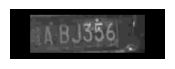

True: 皖CL6D00, pred: 苏A76111


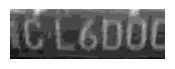

True: 吉BTW976, pred: 皖ADWA97


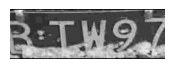

True: 皖LXG035, pred: 湘AXCG13


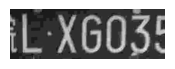

In [19]:
n_errors = (test_labels != test_predictions).sum(axis=1)

for idx in np.arange(len(test_dataset))[n_errors == 6]:
    plt.figure(figsize=(2, 1))
    plt.imshow((test_dataset[idx]["img"].permute(1, 2, 0) * 255).to(torch.uint8), cmap="gray")
    print(f"True: {convert_labels_to_name(test_labels[idx].numpy())}, pred: {convert_labels_to_name(test_predictions[idx].numpy())}")
    plt.axis('off')
    plt.show()

True: 皖AVD028, pred: 皖AJ1265


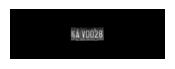

True: 皖RL222P, pred: 皖AG727S


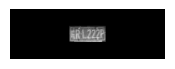

True: 皖A83453, pred: 鲁BFK463


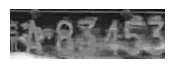

True: 皖NTA088, pred: 皖AJ4108


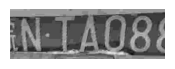

True: 皖SY0932, pred: 皖AYC163


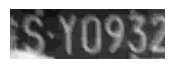

True: 苏B200QB, pred: 苏A2CH1Q


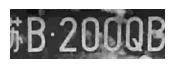

True: 皖N1G886, pred: 粤AYG823


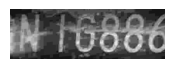

True: 鄂A02SU9, pred: 皖A1262U


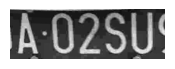

True: 皖A75W76, pred: 皖7Z5J91


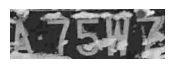

True: 皖AK927W, pred: 皖A246A4


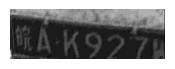

True: 皖EW666K, pred: 豫AK6656


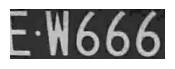

In [20]:
n_errors = (test_labels != test_predictions).sum(axis=1)

for idx in np.arange(len(test_dataset))[n_errors == 5]:
    plt.figure(figsize=(2, 1))
    plt.imshow((test_dataset[idx]["img"].permute(1, 2, 0) * 255).to(torch.uint8), cmap="gray")
    print(f"True: {convert_labels_to_name(test_labels[idx].numpy())}, pred: {convert_labels_to_name(test_predictions[idx].numpy())}")
    plt.axis('off')
    plt.show()